In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ExponentialLR

from sklearn.model_selection import train_test_split
import monai
from PIL import Image, ImageOps


import torch.optim as optim
import random
import timm

MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


In [2]:
### 设置参数
images_file = '../GOALS2022-Train/Train/Image'  # 训练图像路径
gt_file = '../GOALS2022-Train/Train/Layer_Masks'
image_size = 800 # 输入图像统一尺寸
image_size2 = 1120
val_ratio = 0.3  # 训练/验证图像划分比例
batch_size = 4 # 批大小
iters = 10000 # 训练迭代次数
optimizer_type = 'adam' # 优化器, 可自行使用其他优化器，如SGD, RMSprop,...
num_workers = 8 # 数据加载处理器个数
init_lr = 1e-3 # 初始学习率

summary_dir = './logs'
torch.backends.cudnn.benchmark = True
print('cuda',torch.cuda.is_available())
print('gpu number',torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
summaryWriter = SummaryWriter(summary_dir)

cuda True
gpu number 1
NVIDIA RTX A6000


In [3]:
val_ratio = 0.2
filelists = os.listdir(images_file)
print(filelists)
train_filelists, val_filelists = train_test_split(filelists, test_size = val_ratio)
print("Total Nums: {}, train: {}, val: {}".format(len(filelists), len(train_filelists), len(val_filelists)))

['0046.png', '0069.png', '0013.png', '0047.png', '0099.png', '0084.png', '0086.png', '0015.png', '0083.png', '0043.png', '0055.png', '0035.png', '0038.png', '0005.png', '0027.png', '0039.png', '0011.png', '0060.png', '0041.png', '0002.png', '0004.png', '0028.png', '0091.png', '0068.png', '0007.png', '0088.png', '0061.png', '0010.png', '0076.png', '0079.png', '0057.png', '0066.png', '0018.png', '0096.png', '0082.png', '0090.png', '0067.png', '0029.png', '0052.png', '0032.png', '0078.png', '0036.png', '0016.png', '0064.png', '0093.png', '0100.png', '0044.png', '0070.png', '0001.png', '0040.png', '0034.png', '0062.png', '0087.png', '0075.png', '0023.png', '0024.png', '0012.png', '0095.png', '0026.png', '0054.png', '0089.png', '0050.png', '0065.png', '0077.png', '0048.png', '0006.png', '0009.png', '0045.png', '0056.png', '0073.png', '0008.png', '0085.png', '0058.png', '0014.png', '0030.png', '0049.png', '0037.png', '0017.png', '0020.png', '0031.png', '0033.png', '0092.png', '0059.png', '00

In [4]:
# 数据加载
class GOALS_sub2_dataset(Dataset):
    def __init__(self,
                dataset_root,
                label_file='',
                filelists=None,
                mode='train'):
        self.dataset_root = dataset_root

        self.mode = mode

        if self.mode == 'train' or self.mode == "val" :  
            label = {row['ImgName']:row[1]
                    for _, row in pd.read_excel(label_file,engine='openpyxl').iterrows()}
            self.file_list = [[f, label[int(f.split('.')[0])]] for f in os.listdir(dataset_root)]

        elif self.mode == "test":
            self.file_list = [[f, None] for f in os.listdir(dataset_root)]
        
        if filelists is not None:
            self.file_list = [item for item in self.file_list if item[0] in filelists]
    
    def __getitem__(self, idx):

        real_index, label = self.file_list[idx]
        #label = [label]
        img_path = os.path.join(self.dataset_root, real_index)    
        img = Image.open(img_path)
        img = ImageOps.grayscale(img)
        # img = img.resize((image_size2,image_size))
        # normlize on GPU to save CPU Memory and IO consuming.
        # img = (img / 255.).astype("float32")
        if self.mode == "train":
            im_aug = transforms.Compose([
                #tfs.Resize(120),
                transforms.RandomCrop(image_size),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(20),
                #transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
                #transforms.RandomPerspective(),
                #transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.5)),
                #transforms.RandomInvert(),
                #transforms.RandomPosterize(bits=2),
                #transforms.RandomAdjustSharpness(sharpness_factor=2)
                #transforms.RandomAutocontrast(),
                #transforms.RandomEqualize()
            ])
            img = im_aug(img)
        
        
        
        if self.mode == 'test' or self.mode == "val":    
            im_aug = transforms.Compose([
                transforms.CenterCrop(image_size)
            ])
            img = im_aug(img)
        
        img = transforms.PILToTensor()(img)
        #print(img.shape)

        #img = img.transpose(2, 0, 1) # H, W, C -> C, H, W

        if self.mode == 'test':
            return img, real_index

        if self.mode == "train" or self.mode == "val" :           
            return img, label

    def __len__(self):
        return len(self.file_list)

(1, 800, 800)
0
(1, 800, 800)
1
(1, 800, 800)
0
(1, 800, 800)
1
(1, 800, 800)
0
(1, 800, 800)
0
(1, 800, 800)
0
(1, 800, 800)
1
(1, 800, 800)
0
(1, 800, 800)
1


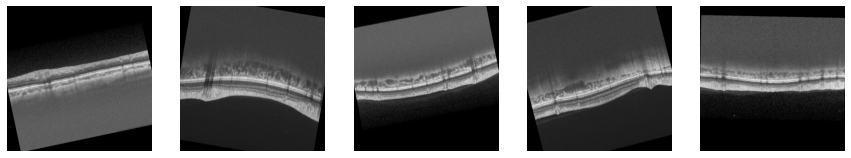

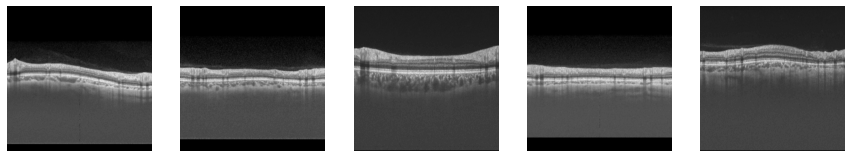

In [5]:
# 可视化并检查数据加载
_train = GOALS_sub2_dataset(dataset_root=images_file, 
                            label_file = '../GOALS2022-Train/Train/Train_GC_GT.xlsx',
                            filelists = train_filelists,
                            mode = 'train')

plt.figure(figsize=(15, 5))

for i in range(5):
    img, lab = _train.__getitem__(i)
    img = img.numpy()
    print(img.shape)
    print(lab)
    plt.subplot(1, 5, i+1)
    plt.imshow(img.transpose(1, 2, 0),cmap='gray')
    plt.axis("off")

_val = GOALS_sub2_dataset(dataset_root=images_file, 
                          label_file = '../GOALS2022-Train/Train/Train_GC_GT.xlsx',
                          filelists = val_filelists,
                          mode = 'val')

plt.figure(figsize=(15, 5))
for i in range(5):
    img, lab = _val.__getitem__(i)
    img = img.numpy()
    print(img.shape)
    print(lab)
    plt.subplot(1, 5, i+1)
    plt.imshow(img.transpose(1, 2, 0),cmap='gray')
    plt.axis("off")

In [6]:
# 预测
best_model_path = '/home/liyihao/OVH/home/yihao/GOALS/src/Task2/resnet50_model41_1.0.pth'
model = timm.create_model('resnet50', pretrained=False, num_classes=2, in_chans=1)
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [7]:
model1_path = '/home/liyihao/OVH/home/yihao/GOALS/src/Task2/resnet101_model50_1.0.pth'
model1 = timm.create_model('resnet101', pretrained=True, num_classes=2, in_chans=1)
model1.load_state_dict(torch.load(model1_path))

<All keys matched successfully>

In [8]:
model.cuda()
model1.cuda()
model.eval()
model1.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act3): ReLU(inplace=True)
      (downsample): Sequen

In [9]:
test_root = "../GOALS2022-Validation/GOALS2022-Validation/Image"
test_dataset = GOALS_sub2_dataset(dataset_root=test_root, mode='test')

In [10]:
cache = []
for img, idx in test_dataset:
    img = img.unsqueeze(0).float()
    img = img.cuda()
    #print(img.shape)
    #print(idx)
    #print(abc)
    #img = img[np.newaxis, ...]
    #img = paddle.to_tensor((img / 255.).astype("float32"))
    logits = model(img) 
    logits1 = model1(img)
    logits_ensm = 0.5*logits + 0.5*logits1
    m = nn.Softmax()
    pred = m(logits_ensm).detach().cpu().numpy()
    print([idx, pred[0][1]])
    #print(pred[0])
    #print(abc)
    cache.append([idx, pred[0][1]])

submission_result = pd.DataFrame(cache, columns=['ImgName', 'GC_Pred'])
submission_result[['ImgName', 'GC_Pred']].to_csv("Classification_Results.csv", index=False)

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


['0200.png', 0.00031379773]
['0137.png', 0.9997204]
['0112.png', 0.99991405]
['0162.png', 0.00054559973]
['0190.png', 0.9998882]
['0175.png', 0.9980914]
['0145.png', 0.00060704]
['0165.png', 0.9998658]
['0118.png', 0.011921435]
['0143.png', 0.0004275381]
['0117.png', 0.00041379922]
['0133.png', 0.0037137647]
['0119.png', 0.0064727785]
['0107.png', 0.005652405]
['0144.png', 0.0020053536]
['0158.png', 0.0006374005]
['0193.png', 0.9999808]
['0196.png', 0.9997521]
['0164.png', 0.9999198]
['0136.png', 0.99985695]
['0169.png', 0.00027230746]
['0189.png', 0.9998667]
['0154.png', 0.99985754]
['0163.png', 0.9999709]
['0177.png', 0.99988985]
['0188.png', 0.0002890319]
['0122.png', 0.99995875]
['0124.png', 0.0016287867]
['0199.png', 0.999969]
['0126.png', 0.9998703]
['0142.png', 0.0015711025]
['0151.png', 0.00016901434]
['0111.png', 0.99989426]
['0182.png', 0.9999658]
['0198.png', 0.9999639]
['0152.png', 0.003275315]
['0155.png', 0.9997465]
['0116.png', 0.00047779398]
['0106.png', 0.99965525]
['0